### Imports

In [1]:
import pickle

import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline

import gym
gym.logger.set_level(40)

import os
# print(os.environ['LD_LIBRARY_PATH'])

import load_policy
import tf_util

In [2]:
import mujoco_py

Load expert policy.

In [3]:
policy_fn = load_policy.load_policy('./experts/Hopper-v2.pkl')

obs (1, 11) (1, 11)


In [4]:
with open('./expert_policy_Hopper-v2.pkl', 'rb') as pkl:
    data_train = pickle.load(pkl)

### My Code

#### Behavioral Cloning (Direct)

In [5]:
observ = tf.placeholder(shape=(None, 11), dtype=tf.float64, name='observ')

with tf.name_scope('fc1'):
    hidden1 = tf.contrib.layers.fully_connected(observ,
        num_outputs=128, activation_fn=tf.nn.relu)
with tf.name_scope('fc2'):
    hidden2 = tf.contrib.layers.fully_connected(hidden1,
        num_outputs=256, activation_fn=tf.nn.relu)
with tf.name_scope('fc3'):
    hidden3 = tf.contrib.layers.fully_connected(hidden2,
        num_outputs=64, activation_fn=tf.nn.relu)
with tf.name_scope('fc_out'):
    action_hat = tf.contrib.layers.fully_connected(hidden3,
        num_outputs=3, activation_fn=None)

In [6]:
action_expert = tf.placeholder(shape=[None, 1, 3], dtype=tf.float64, name='action_exp')
mseloss = tf.reduce_mean(tf.squared_difference(action_hat, action_expert))
train_op = tf.train.GradientDescentOptimizer(0.01).minimize(mseloss)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

env = gym.make('Hopper-v2')

In [7]:
def get_random_batch(dataset=data_train, batch_size=200):
    ttl_size = len(dataset['observations'])
    choices = np.random.choice(ttl_size, batch_size, replace=False)
    return (
        dataset['observations'][choices],
        dataset['actions'][choices]
    )

In [8]:
def run_our_model_once(
        model_input=observ,
        env=env,
        render=False):
    
    last_observ = env.reset()
    done = False
    reward = 0
    
    while not done:
        action = sess.run(action_hat,
                          feed_dict={
                                model_input: np.array([last_observ])
                          })
        last_observ, step_reward, done, _ = env.step(action)
            
        reward += step_reward
    
    return reward

In [9]:
train_loss_rec = []
reward_rec = []

train_size = data_train['observations'].shape[0]

for step_cnt in range(500):
    perm = np.random.permutation(train_size)
    train_loss_ttl = 0
    for cut in range(0, train_size, 20):
        train_loss, _ = sess.run([mseloss, train_op],
                                 feed_dict={
                                    observ: data_train['observations'][cut:cut + 20],
                                    action_expert: data_train['actions'][cut:cut + 20]
                                 })
        train_loss_ttl += train_loss
    train_loss_rec.append(train_loss_ttl / train_size)
    reward_rec.append(run_our_model_once())

    print('step {}, training loss {:.4f}, with reward {:.4f}'.format(step_cnt,
                                                                     train_loss,
                                                                     reward_rec[-1]) \
              + ' ' * 20,
          end='\r')
    if step_cnt % 100 == 0:
        print()  # new line

step 0, training loss 0.9926, with reward 62.6905                    
step 100, training loss 0.9623, with reward 38.8519                    
step 200, training loss 0.9605, with reward 49.2520                     
step 300, training loss 0.9584, with reward 85.7031                     
step 400, training loss 0.9606, with reward 85.2952                     


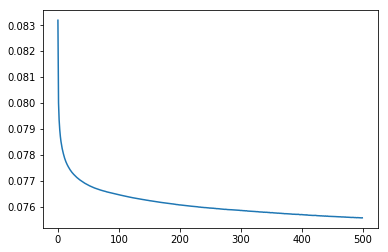

In [10]:
plt.plot(train_loss_rec)
plt.show()

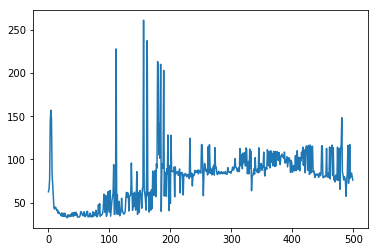

In [11]:
plt.plot(reward_rec)
plt.show()

#### DAgger

In [12]:
def DAgger(
        model_input=observ,
        model_output=action_hat,
        env=env,
        dataset=data_train):

    observ_rec = []
    action_prd_rec = []
    action_exp_rec = []
    
    last_observ = env.reset()
    done = False
    cnt = 0

    # run in real env with current policy
    while not done:
        cnt += 1
        observ_rec.append(last_observ)

        step_action_hat = sess.run(model_output,
                                   feed_dict={ model_input: np.array([last_observ]) })
        step_action_exp = policy_fn(last_observ[None, :])

        action_prd_rec.append(step_action_hat)
        action_exp_rec.append(step_action_exp)

        last_observ, _, done, _ = env.step(step_action_hat)

    action_prd_rec, action_exp_rec, observ_rec = \
        np.array(action_prd_rec), np.array(action_exp_rec), np.array(observ_rec)
        
    # aggregate data
    dataset['observations'] = \
        np.append(data_train['observations'], observ_rec, axis=0)
    dataset['actions'] = \
        np.append(data_train['actions'], action_exp_rec, axis=0)
    
    return observ_rec, action_prd_rec, action_exp_rec

In [13]:
def reset_dataset(dataset=data_train, orig_size=1000):
    dataset['observations'] = dataset['observations'][:orig_size]
    dataset['actions'] = dataset['actions'][:orig_size]

In [14]:
# reset_dataset()

In [15]:
tf.global_variables_initializer().run()

train_loss_rec = []
reward_rec = []

for step_cnt in range(500):
    
    for _ in range(5):
        DAgger()

    train_size = data_train['observations'].shape[0]
    perm = np.random.permutation(train_size)

    train_loss_ttl = 0
    
    for cut in range(0, train_size, 20):
        train_loss, _ = sess.run([mseloss, train_op],
                                 feed_dict={
                                    observ: data_train['observations'][cut:cut + 20],
                                    action_expert: data_train['actions'][cut:cut + 20]
                                 })
        train_loss_ttl += train_loss
    train_loss_rec.append(train_loss_ttl / train_size)
    reward_rec.append(run_our_model_once())
    
    print('step {}, training loss {:.4f}, with reward {:.4f}'.format(step_cnt,
                                                                     train_loss,
                                                                     reward_rec[-1]) \
              + ' ' * 20,
          end='\r')
    if step_cnt % 100 == 0:
        print()  # new line

step 0, training loss 4.0450, with reward 40.3970                    
step 100, training loss 1.7905, with reward 3481.6500                    
step 200, training loss 1.1730, with reward 807.9575                     
step 300, training loss 1.4452, with reward 965.9765                     
step 400, training loss 1.8438, with reward 1154.1369                    


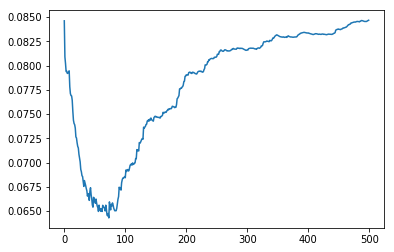

In [16]:
plt.plot(train_loss_rec)
plt.show()

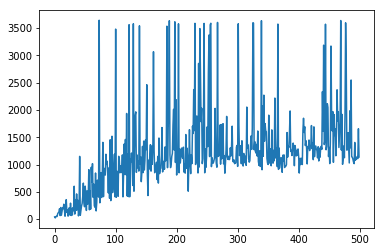

In [17]:
plt.plot(reward_rec)
plt.show()